# Module 4 Project: NLP Model to Guage Tweet Sentiment

 The goal of this project was to take raw twitter data, preprocess it, clean it, explore the tweet data using various statistics, and then create a NLP binary classifier with Sklearn.

# Setting up

In [46]:
from imblearn.over_sampling import SMOTE
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist, regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             f1_score, 
                             recall_score, 
                             accuracy_score,
                             precision_score,
                             plot_confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import string
import pandas as pd


def combine_documents(series):
    return [token for tweet in series for token in tweet]
    
def get_perf_metrics(X_train, y_train, X_test, y_test, clf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    print('Training metrics:')
    y_pred_train = clf.predict(X_train)
    print_scores(y_train, y_pred_train)
    ax1.set_title('Train Confusion Matrix')
    plot_confusion_matrix(clf, X_train, y_train,
                          cmap=plt.cm.Blues,
                          values_format = '',
                          # normalize='true',
                         ax=ax1)    
    print()
    print('Test metrics')
    y_pred_test = clf.predict(X_test)
    print_scores(y_test, y_pred_test)
    ax2.set_title('Test Confusion Matrix')
    plot_confusion_matrix(clf, X_test, y_test,
                          cmap=plt.cm.Blues,
                          values_format = '',
                          # normalize='true',
                          ax=ax2);

def print_scores(y_true, y_pred):
    print(f'f1_score: {round(f1_score(y_true, y_pred), 3)}')
    print(f'accuracy_score: {round(accuracy_score(y_true, y_pred), 3)}')
    print(f'recall_score: {round(recall_score(y_true, y_pred), 3)}')
    print(f'precision_score: {round(precision_score(y_true, y_pred), 3)}')

In [2]:
# Read in CSV file ignoring and dropping non-utf8 characters
csv_file = open('judge-1377884607_tweet_product_company.csv', encoding='utf-8', errors='ignore')

In [3]:
# Create the dataframe
df = pd.read_csv(csv_file)

In [4]:
# Rename columns with really long names
df.columns = ['tweet_text', 'emotion_directed_at', 'emotion_directed_at_brand']

In [5]:
# Inspecting columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                   9092 non-null object
emotion_directed_at          3291 non-null object
emotion_directed_at_brand    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Inspecting values
df.head()

,tweet_text,emotion_directed_at,emotion_directed_at_brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
# Closer look at tweet_text column
df.tweet_text

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offe...
Name: tweet_text, Length: 9093, dtype: object

Alright, now that we have a pretty good idea of what the data looks like let's get to cleanin'!

## Preprocessing data

The biggest problem that I see first is that the our target variable, "emotion_directed_at_brand", includes many values that are "No emotion toward brand or product".

In [8]:
# The current classes and their counts
df.emotion_directed_at_brand.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion_directed_at_brand, dtype: int64

 In fact, 59% of responses were "No emotion toward brand or product".

In [9]:
# Percentage of labels that were 'No emotion toward brand or product'?
len(df.loc[df.emotion_directed_at_brand == 'No emotion toward brand or product']) / len(df)

0.5926536896513802

Our main goal is to be able to correctly classify positive and negative tweets. Rather than train our data on a dataset that has 3 or 4 ambiguous classes, including a classification for "I can't tell", we'll use a subset of the data that includes only those tweets that were definitively positive or negative. This way our model will learn the true meaningful differences between the two outcomes rather than being trained on noisy, meaningless data.

In [10]:
# Drop the 'No emotion toward brand or product' rows
drop_no_emotion = df.loc[df.emotion_directed_at_brand == 'No emotion toward brand or product'].index
df = df.drop(drop_no_emotion)

In [11]:
# Also drop "I can't tell" rows
drop_cant_tell = df.loc[df.emotion_directed_at_brand == "I can't tell"].index
df = df.drop(drop_cant_tell)

In [12]:
# There are only two classes now
df.emotion_directed_at_brand.unique()

array(['Negative emotion', 'Positive emotion'], dtype=object)

Perfect. Now we have only two classes. Let's binarize them by converting them to 0s and 1s instead of their string representations.

In [13]:
# Binarize emotion_directed_at_brand
df.emotion_directed_at_brand = df.emotion_directed_at_brand.map(lambda x: 1 if x == 'Positive emotion' else 0)

In [14]:
# Everything looks good, 2 classes (0 and 1)
df.emotion_directed_at_brand.value_counts()

1    2978
0     570
Name: emotion_directed_at_brand, dtype: int64

There may be class imbalance problems. It looks like the positive comments outweigh the negative comments 6:1. We'll run the model without solving that first then address it if needed later.

Now that the target variables is cleaned up a bit, let's start tokenizing the tweets to prepare them to be modeled.

In [15]:
# TODO: Change Regex because tokens aren't correct
# Pattern to capture words with apostrophes as one token
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# Casting tweet_text to string or the tokenization doesn't work
df['tweet_text'] = df['tweet_text'].astype('str')

# Tokenizing tweets and inserting into df
df['raw_tokens'] = df['tweet_text'].map(lambda x: regexp_tokenize(x, pattern))

# Lowercase all tokens
df['raw_tokens'] = df['raw_tokens'].map(lambda x: [y.lower() for y in x])

In [16]:
# Verify that the tokenization worked correctly
df[['tweet_text', 'raw_tokens']].loc[:10]

,tweet_text,raw_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[wesley, i, have, a, g, iphone, after, hrs, tw..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw I hope this year's festival isn't as cra...,"[sxsw, i, hope, this, year's, festival, isn't,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."
7,"#SXSW is just starting, #CTIA is around the co...","[sxsw, is, just, starting, ctia, is, around, t..."
8,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, and, simple, idea, rt, ma..."
9,Counting down the days to #sxsw plus strong Ca...,"[counting, down, the, days, to, sxsw, plus, st..."
10,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, to, meet, the, samsungmobileus, at, ..."


Let's take a quick look at the most common words in our corpus...

In [17]:
# Create bag of words by getting frequency distribution of all words
all_words_raw = combine_documents(df.raw_tokens)
tweets_freq_dist = FreqDist(all_words_raw)

In [18]:
# Top 25 most common words in tweet corpus
tweets_freq_dist.most_common(25)

[('sxsw', 3736),
 ('mention', 2507),
 ('the', 1911),
 ('ipad', 1449),
 ('to', 1419),
 ('link', 1319),
 ('at', 1167),
 ('rt', 1075),
 ('for', 1029),
 ('apple', 1011),
 ('a', 956),
 ('google', 830),
 ('is', 807),
 ('of', 772),
 ('in', 761),
 ('iphone', 711),
 ('and', 679),
 ('quot', 639),
 ('store', 596),
 ('i', 590),
 ('on', 542),
 ('up', 510),
 ('app', 461),
 ('it', 431),
 ('my', 408)]

Clearly we need to remove stopwords and then I think we'll be done and ready to start exploring the dataset!

In [19]:
# Remove stopwords
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
df['raw_tokens_stopped'] = df['raw_tokens'].map(lambda x: [y for y in x if y not in stopwords_list])

# Corpus Statistics

As a first look into our body of tweet text, let's see the frequency distribution of our new tokens with stopwords removed.

In [20]:
# Frequency distribution of new tokens
all_words_stopped = combine_documents(df.raw_tokens_stopped)
tweets_freq_dist = FreqDist(all_words_stopped)
freq_dist_top_25 = tweets_freq_dist.most_common(25)
freq_dist_top_25

[('sxsw', 3736),
 ('mention', 2507),
 ('ipad', 1449),
 ('link', 1319),
 ('rt', 1075),
 ('apple', 1011),
 ('google', 830),
 ('iphone', 711),
 ('quot', 639),
 ('store', 596),
 ('app', 461),
 ('new', 403),
 ('austin', 323),
 ('amp', 233),
 ('android', 233),
 ('pop', 231),
 ('get', 182),
 ('launch', 182),
 ('circles', 156),
 ('social', 155),
 ('like', 154),
 ('line', 150),
 ('time', 147),
 ('via', 146),
 ('great', 145)]

## What is the total vocabulary size of our dataset?

In [21]:
# Vocabulary size
len(set(all_words_stopped))

5753

## What is the normalized word frequency (percentage of total words)?

In [22]:
# Normalized word frequencies
for word in freq_dist_top_25:
    normalized_frequency = word[1] / len(all_words_stopped)
    print(f'{word[0]:15}{normalized_frequency:.3}')

sxsw           0.0851
mention        0.0571
ipad           0.033
link           0.03
rt             0.0245
apple          0.023
google         0.0189
iphone         0.0162
quot           0.0146
store          0.0136
app            0.0105
new            0.00918
austin         0.00735
amp            0.00531
android        0.00531
pop            0.00526
get            0.00414
launch         0.00414
circles        0.00355
social         0.00353
like           0.00351
line           0.00342
time           0.00335
via            0.00332
great          0.0033


## Making bigrams from tweets to find common word phrases in our corpus

Rather than just relying on the frequencies of individual words, it may be more informative to see the frequency distribution of bigrams or word pairs. Creating bigrams is one way to vectorize the text in preparation for modeling but we'll actually end up using a different vectorizer. More on that later. For now, bigrams!

In [23]:
# Find and score the frequencies of bigrams
tweet_bigram_finder = BigramCollocationFinder.from_words(all_words_stopped)
tweet_bigram_scored = tweet_bigram_finder.score_ngrams(BigramAssocMeasures().raw_freq)
tweet_bigram_scored[:25]

[(('rt', 'mention'), 0.02381765603297129),
 (('sxsw', 'link'), 0.007719106496345379),
 (('mention', 'sxsw'), 0.005988569346722226),
 (('sxsw', 'rt'), 0.005851947992804609),
 (('apple', 'store'), 0.005533164833663501),
 (('link', 'sxsw'), 0.005214381674522394),
 (('sxsw', 'mention'), 0.004235261971446137),
 (('mention', 'mention'), 0.004075870391875584),
 (('iphone', 'app'), 0.003620465878816859),
 (('link', 'rt'), 0.0035521552018580502),
 (('sxsw', 'apple'), 0.003210601817064007),
 (('sxsw', 'ipad'), 0.0031422911401051985),
 (('ipad', 'sxsw'), 0.0031195209144522624),
 (('pop', 'store'), 0.0030739804631463898),
 (('mention', 'google'), 0.0028918186579229),
 (('store', 'sxsw'), 0.0028918186579229),
 (('via', 'mention'), 0.0027551973040052828),
 (('austin', 'sxsw'), 0.002504724821822984),
 (('mention', 'apple'), 0.002368103467905367),
 (('mention', 'rt'), 0.002368103467905367),
 (('social', 'network'), 0.002254252339640686),
 (('new', 'social'), 0.0021176309857230684),
 (('google', 'maps'

# Modeling the data

Alright, so vectorization. We'll use a technique called TF-IDF vectorization. The TF-IDF score is a statistical measure to indicate any given term's importance within a document. The TF-IDF vectorizer will take our training data as input and will output a sparse matrix of features which can be fed to our model.

In [24]:
# Recreate tweet documents after preprocessing steps turned them into lists
df['cleaned_doc'] = df.raw_tokens_stopped.map(lambda x: ' '.join(x))

In [25]:
# Implement train/test split of dataset
X_train, X_test, y_train, y_test = train_test_split(
    df.cleaned_doc, df.emotion_directed_at_brand, test_size=0.20, random_state=42)

## Vectorize the data

In [26]:
# Instantiate vectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

In [27]:
# How many rows and columns in our finished training set
tf_idf_X_train.shape

(2838, 5096)

In [28]:
# How many rows and columns in our finished test set
tf_idf_X_test.shape

(710, 5096)

## Train a baseline Random Forest model with no tuning

In [42]:
# Instantiate RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=20)

In [43]:
# Train the RandomForestClassifier model
rf_classifier.fit(tf_idf_X_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_X_train)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

Training metrics:
f1_score: 0.998
accuracy_score: 0.996
recall_score: 1.0
precision_score: 0.996

Test metrics
f1_score: 0.927
accuracy_score: 0.869
recall_score: 0.988
precision_score: 0.872


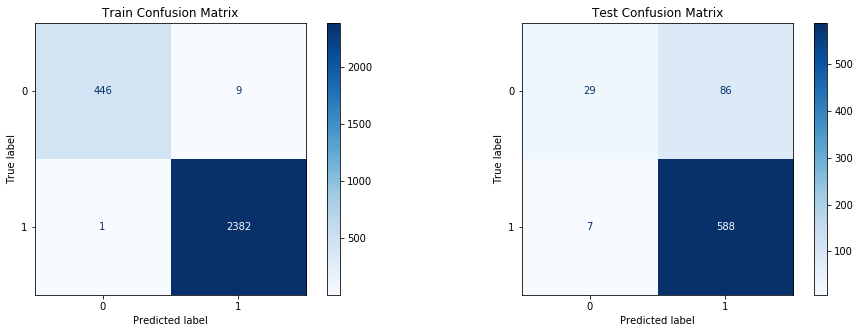

In [44]:
# Get performance metrics
get_perf_metrics(tf_idf_X_train, y_train, tf_idf_X_test, y_test, rf_classifier)

## Initial observations:
* **Performance metrics are too high:** These are some pretty high performance metrics (all perfect scores for training, and almost perfect recall in test set), at first glance it seems like everything is going well. Who doesn't love high numbers? But the real issue here is that the model is almost always predicting 1s. Even a terrible model that always predicts 1 will have a perfect recall.
* **Overfitting:** The random forest classifier is seriously overfit, which we'd expect with a sparse matrix of over 5000 features and no regularization.
* **Class Imbalance:** We still see that there's a class imbalance problem with our positive labels occuring 6 times as often as the negative labels. In the test set, our model only predicted a negative sentiment 30 out of 595 times or 5% even though the correct portion of negative tweets was closer to 16%. This issue is likely a symptom of the class imbalance present in the training data. The class imbalance issue also contributes to deceiving but very high performance metrics.

# Tuning the model

## Resample to solve class imbalance

In [32]:
# Previous original class distribution
y_train.value_counts()

1    2383
0     455
Name: emotion_directed_at_brand, dtype: int64

In [33]:
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(tf_idf_X_train, y_train)

In [36]:
# Check that new class proportions are correct
pd.Series(y_train_resampled).value_counts()

1    2383
0    2383
Name: emotion_directed_at_brand, dtype: int64

In [38]:
# Instantiate new RandomForestClassifier
smote_rf_classifier = RandomForestClassifier(n_estimators=100)

In [39]:
# Retrain the RandomForestClassifier model this time with SMOTE
smote_rf_classifier.fit(X_train_resampled, y_train_resampled)
rf_train_preds = smote_rf_classifier.predict(tf_idf_X_train)
rf_test_preds = smote_rf_classifier.predict(tf_idf_X_test)

Training metrics:
f1_score: 1.0
accuracy_score: 1.0
recall_score: 1.0
precision_score: 1.0

Test metrics
f1_score: 0.926
accuracy_score: 0.869
recall_score: 0.983
precision_score: 0.876


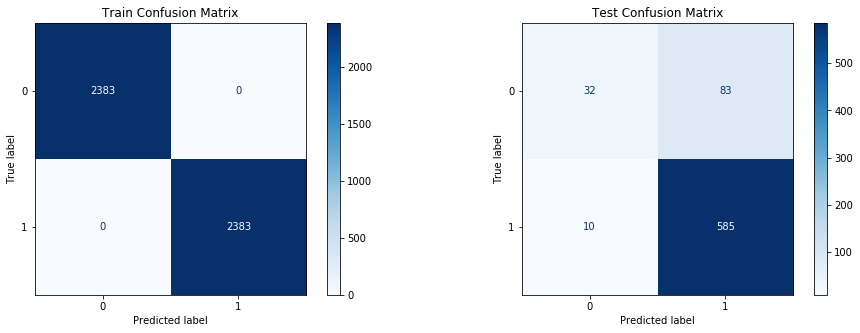

In [52]:
# Get performance metrics
get_perf_metrics(X_train_resampled, y_train_resampled, tf_idf_X_test, y_test, smote_rf_classifier)

Bummer. It seems like the class imbalance problem wasn't contributing as much as we thought to the model's behavior of always predicting positive tweet sentiment. Though our model did predict a negative sentiment a tiny bit more. Before we fixed the class imbalance our model only predicted 30 negative sentiments, our new SMOTE model predicted 42. Now that we've addressed the imbalance, let's tune the models hyperparameters to see if we can generalize a bit and reduce the overfitting.

## Gridsearching hyperparameters to reduce overfitting

Now we'll try to make our model a bit more generalized by tweaking its hyperparameter values with GridsearchCV.

In [57]:
# Takes 4 minutes to run.

# Instantiate classifier
rf_clf = RandomForestClassifier()

# Parameter grid
grid = {
    'n_estimators': [30, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

gridsearch_smote_rf_clf = GridSearchCV(rf_clf, grid, cv=3)
gridsearch_smote_rf_clf.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6, 10],
                         'min_samples_leaf': [1, 3, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 100, 200]})

In [58]:
# The best combination of parameters in the grid
gridsearch_smote_rf_clf.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Training metrics:
f1_score: 1.0
accuracy_score: 1.0
recall_score: 1.0
precision_score: 1.0

Test metrics
f1_score: 0.923
accuracy_score: 0.862
recall_score: 0.983
precision_score: 0.869


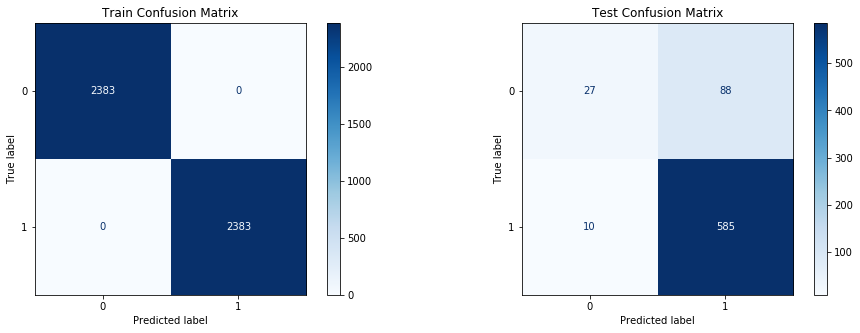

In [59]:
get_perf_metrics(X_train_resampled, y_train_resampled, tf_idf_X_test, y_test, gridsearch_smote_rf_clf)

That's interesting. The best combination of paramaters tended to be an overfit random forest. You can see that the best performing model was the model that allowed the classifier to become as overfit and complex as it could (ie. No max_depth, highest number of estimators at 200, lowest min_samples_leaf).

This leads me to think that we've gotten to the end of the road for our model as it stands. Maybe we could try a different classifier instead of using a random forest, but I think the real problem is that we just don't have enough data. Not including the synthetic data that we generated with SMOTE, our whole corpus only consisted of 3548 tweets of which only ~16% were negative cases.